In [1]:
from joblib import Memory
import sklearn.datasets as sd
from sklearn import svm
import scipy.sparse as sparse

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import dask
import dask.dataframe as dd
import dask.array as da
dask.config.set(scheduler='threads')

In [4]:
filelist = ["./url_svmlight/Day%s.svm" % i for i in range(0,121)]

In [5]:
def descriptiveStat (x):
    print ('Dataset lenght:', x.size)
    print ('Minimum value:', np.min(x))
    print ('Maximum value:', np.max(x))
    print ('Mean value:', np.mean(x))
    #print ('Median value:', np.median(x))

## Import file using sklearn datasets

In [6]:
mem = Memory("./cache")

In [7]:
@mem.cache
def get_data():
    data = sd.load_svmlight_files(filelist)
    return data

In [8]:
data = get_data()

In [9]:
days = np.array([(data[i], data[i+1]) for i in range(0, len(data)) if i%2==0])

In [11]:
len(days)

121

In [12]:
day0 = days[0]
day1 = days[1]

# Testing all days

In [26]:
totalurls = np.empty(0)

for day in days:
    totalurls =np.append(totalurls, day[1])

In [27]:
totalurls

array([-1., -1., -1., ...,  1., -1., -1.])

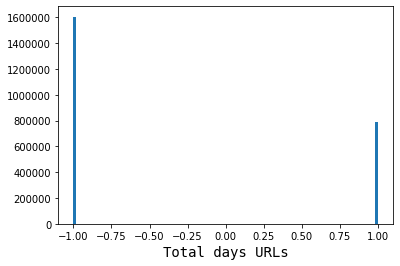

In [28]:
plt.hist(totalurls, 100)
plt.xlabel("Total days URLs", fontdict={'fontsize': 14, 'family': 'monospace'})
plt.show()

<h6> Merge all the attributes into a single numpy matrix so that we can do all the analysis on it </h6>

In [10]:
totalattr = [da.from_array(day[0], chunks=(5000,5000)) for day in days]

In [12]:
totalattr

[dask.array<array, shape=(16000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 dask.array<array, shape=(20000, 3231961), dtype=float64, chunksize=(5000, 5000)>,
 das

<h6>We remove the only to elements with a different shape, since they will complicate our analysis </h6>

In [17]:
for i in range(0, len(totalattr)):
    if totalattr[i].shape != (20000, 3231961):
        print(i)

0
45


In [30]:
new_totalattr = totalattr[1:45]

In [33]:
new_totalattr += totalattr[46:]

In [34]:
for i in range(0, len(new_totalattr)):
    if new_totalattr[i].shape != (20000, 3231961):
        print(i)

## Testing TruncatedSVD

In [37]:
import dask_ml.decomposition as dec

In [38]:
svd = dec.TruncatedSVD(n_components=5)

In [40]:
svd.fit(x)

ValueError: Input must have the following properties:
  1. Have two dimensions
  2. Have only one column of blocks

Note: This function (tsqr) supports QR decomposition in the case of
tall-and-skinny matrices (single column chunk/block; see qr)Current shape: (119, 20000, 3231961),
Current chunksize: (1, 5000, 5000)

# Test for Dask DataFrame on Day 0

In [ ]:
%%timeit
%memit sd.load_svmlight_file('url_svmlight/Day0.svm')

In [ ]:
da_day0 = da.from_array(day0[0])

In [ ]:
da_day0